In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [6]:
#label_to_index = {'Bhoopali': 0, 'Yaman': 1, 'Bhairava': 2}
df = pd.read_csv('audio_features_dataset.csv')

In [7]:
feature_cols = [col for col in df.columns if col.startswith('mfcc_')]
X = df[feature_cols].values
y = df['Ragas'].values
print("Shape of X before reshape:", X.shape)
print("Shape of y before encode:", y.shape)


Shape of X before reshape: (92, 120)
Shape of y before encode: (92,)


In [8]:
# Get the number of MFCC features
num_mfcc = 40
num_time_frames = X.shape[1] // num_mfcc
print(num_time_frames)

3


In [9]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)
print("Shape of y_categorical before split:", y_categorical.shape)

Shape of y_categorical before split: (92, 3)


In [11]:
originallabels = label_encoder.classes_
print("Original labels: ", originallabels)
print("Encoded labels: ", np.unique(y_encoded))

Original labels:  ['Bhairava' 'Bhoopali' 'Yaman']
Encoded labels:  [0 1 2]


In [12]:
#X_reshaped_2d = X.reshape((-1, time_step, num_mfcc))
X_reshaped = X_scaled.reshape(-1, num_mfcc, num_time_frames, 1)
#print("Shape of X_reshaped_2d before split:", X_reshaped_2d.shape)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=127)
X_train_flat = np.array([x.flatten() for x in X_train])
le = LabelEncoder()
y_train_numerical = le.fit_transform(y_train)
y_val_numerical = le.transform(y_val)
y_train_encoded = to_categorical(y_train_numerical, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_numerical, num_classes=num_classes)

In [14]:
print(y_val_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [15]:
print(X_train[0])
print(X_train_flat[0])

[-2.22002749e+02  8.93915367e+01  3.09533509e+01  1.42232030e+01
  1.32982972e+01  2.62227711e+00 -3.56764625e+00 -3.53352136e+00
 -6.25855863e+00 -9.57085538e+00 -1.00237106e+01 -8.65241945e+00
 -7.39504873e+00 -6.25180132e+00 -4.62633221e+00 -5.11102623e+00
 -8.22704033e+00 -1.03719430e+01 -1.13917330e+01 -1.28239043e+01
 -1.11835642e+01 -6.53561661e+00 -5.07650565e+00 -6.45089793e+00
 -7.13032119e+00 -5.63286492e+00 -3.35236080e+00 -4.00102152e+00
 -4.35707440e+00  3.53205014e-01  3.58101756e+00 -3.33166988e-01
 -3.12546833e+00 -1.01817837e+00 -6.67961371e-01 -4.47721305e+00
 -7.97113268e+00 -8.41185161e+00 -7.07327285e+00 -5.13715670e+00
 -6.62695859e-02 -4.14827325e-02  1.77342959e-02  1.94285071e-03
 -5.89261793e-03  8.21872786e-03  4.54768321e-03 -3.24047943e-03
  1.11129839e-03  1.93214590e-03  1.74853063e-03  2.14821921e-04
 -1.46113526e-03 -2.78697955e-03  3.18933993e-03  5.36256139e-03
 -8.81166712e-04 -7.91717219e-04  8.37452034e-03  6.49208339e-03
  1.25328722e-03  2.92872

In [16]:
print("Shape of X_train:", X_train_flat.shape)
print("Shape of input:", X_train_flat.shape[1])

Shape of X_train: (73, 120)
Shape of input: 120


In [17]:
# Build the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=(input_shape, 1)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [18]:
input_shape = X_train_flat.shape[1]
model = create_cnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 118, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 59, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 57, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       114,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,283 (473.76 KB)

 Trainable params: 121,283 (473.76 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_val, y_val_encoded))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step - accuracy: 0.2806 - loss: 1.7316 - val_accuracy: 0.2105 - val_loss: 1.7021
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4096 - loss: 1.2398 - val_accuracy: 0.7895 - val_loss: 0.7416
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6011 - loss: 0.9258 - val_accuracy: 0.6842 - val_loss: 0.6625
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5318 - loss: 0.8912 - val_accuracy: 0.6316 - val_loss: 0.7190
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7067 - loss: 0.6534 - val_accuracy: 0.5789 - val_loss: 0.7964
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7390 - loss: 0.5894 - val_accuracy: 0.8421 - val_loss: 0.5906
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7830 - loss: 0.5249 - val_accuracy: 0.8947 - val_loss: 0.4589
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8974 - loss: 0.4436 - val_accuracy: 0.7368 - val_loss: 0.5791

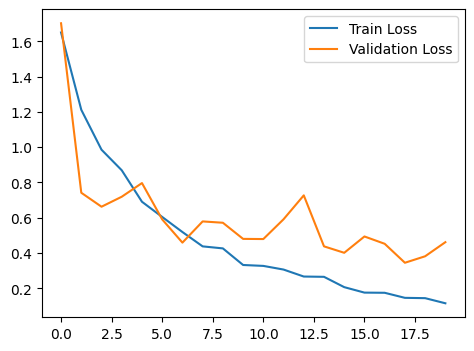

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

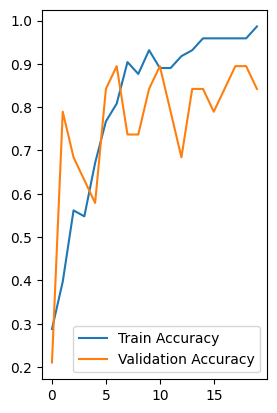

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [23]:
test_df = pd.read_csv('test_dataset.csv')

X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

In [24]:
print (model.input_shape[1])

120


In [25]:
input_shape = model.input_shape[1]
# Reshape the test data
X_test_flat = np.array([x.flatten() for x in X_test])
#X_test = X_test.reshape(X_test.shape[0], input_shape, 1)

In [26]:
y_test_encoded = le.fit_transform(y_test)
num_classes = len(np.unique(y_test_encoded))
y_test_categorical = to_categorical(y_test_encoded, num_classes)

In [27]:
print(y_test_categorical)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [28]:
predictions = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


In [29]:
predicted_classes = np.argmax(predictions, axis=1)
original_predicted_classes = label_encoder.inverse_transform(predicted_classes)

print("Predicted Classes:", original_predicted_classes)

Predicted Classes: ['Bhoopali' 'Bhoopali' 'Bhoopali' 'Yaman' 'Bhoopali' 'Bhoopali' 'Bhoopali'
 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali'
 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali' 'Bhoopali'
 'Bhoopali']


In [30]:
print("Shape of X_test:", X_test_flat.shape)
print("Shape of y_test_categorical:", y_test_categorical.shape)

Shape of X_test: (20, 120)
Shape of y_test_categorical: (20, 3)


In [31]:
print("Data type of X_test:", X_test.dtype)
print("Data type of y_test_categorical:", y_test_categorical.dtype)

Data type of X_test: float64
Data type of y_test_categorical: float64


In [32]:
# Evaluate the model
try:
    loss, accuracy = model.evaluate(X_test_flat, y_test_categorical, verbose=0)
    print(f'Test Loss: {loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
except ValueError as e:
    print(f"Error during evaluation: {e}")

Test Loss: 3.3564
Test Accuracy: 0.2500



Classification Report:
              precision    recall  f1-score   support

    Bhoopali       0.00      0.00      0.00       0.0
       Yaman       0.00      0.00      0.00       0.0
       bhoop       0.00      0.00      0.00       5.0
    bhoopali       0.00      0.00      0.00       5.0
       yaman       0.00      0.00      0.00      10.0

    accuracy                           0.00      20.0
   macro avg       0.00      0.00      0.00      20.0
weighted avg       0.00      0.00      0.00      20.0



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

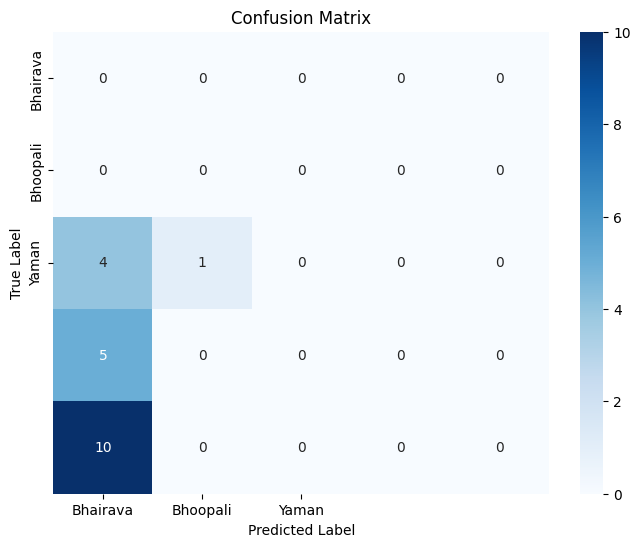

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, original_predicted_classes))
cm = confusion_matrix(y_test, original_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
